In [37]:
using CSV, NamedArrays, DataFrames

stats = CSV.read("FBStats.csv") 
# Full Data Set of players (627 rows)
# 7 Columns: 
# 1(Starter binary variable), 2(Player Name), 3(Team Name), 4(Player position), 5(Off Rating), 6(Def Rating), 7(Team win%)

println(stats)

627×7 DataFrames.DataFrame. Omitted printing of 3 columns
│ Row │ Starter (=1) │ FULL NAME        │ TEAM    │ POS     │
├─────┼──────────────┼──────────────────┼─────────┼─────────┤
│ 1   │ missing      │ missing          │ missing │ missing │
│ 2   │ 1            │ Dewayne Dedmon   │ Atl     │ C       │
│ 3   │ missing      │ Isaac Humphries  │ Atl     │ C       │
│ 4   │ missing      │ Alex Len         │ Atl     │ C       │
│ 5   │ missing      │ Miles Plumlee    │ Atl     │ C       │
│ 6   │ missing      │ Tyler Zeller     │ Atl     │ C       │
│ 7   │ missing      │ Deyonta Davis    │ Atl     │ C       │
│ 8   │ missing      │ DeAndre' Bembry  │ Atl     │ F       │
⋮
│ 619 │ missing      │ Ron Baker        │ Was     │ G       │
│ 620 │ 1            │ Bradley Beal     │ Was     │ G       │
│ 621 │ missing      │ Jordan McRae     │ Was     │ G       │
│ 622 │ missing      │ Gary Payton II   │ Was     │ G       │
│ 623 │ missing      │ Chasson Randle   │ Was     │ G       │
│ 624 │ mi

This CSV is a data set of over 600 players listing their **position** in the lineup, their **name**, **team**, **position**, **offensive rating (OR)**, **defensive rating (DR)**, as well as the **win percentage** of their corresponding teams. It functions as the primary resource for determining the **300 players** we use in our first optimization problem and the **30 players** used in the second problem. 

## Determine the best bench players per team

In [2]:
# Reduce the data set to the 5 best starters and 5 best bench players for all 30 teams (150 starters, 150 bench players)

function fCenter(i) # If column 6 of player index i is C(enter)
    if (length(c) == 0) # Are there any centers
        push!(c, i) # No centers, push player onto array c[] (array size 1)
    elseif ((stats[c[1],5] - stats[c[1], 6]) < (stats[i, 5] - stats[i, 6])) # Is the current indexed center a better Center
        c[1] = i # Replace the center with the "superior" player
    end
end

function fForward(i) # If column 6 of player index i is F(orward)
    if (length(f) == 0) # Are there any forwards
        push!(f, i) # No forwards, push player onto array f[] (array size 2)
    # Is the current forward superior to the forward at index 1 of f[]
    elseif ((stats[f[1],5] - stats[f[1], 6]) <= (stats[i, 5] - stats[i, 6])) 
        if length(f) != 1 # Are there 2 forwards in f
            pop!(f) # Remove player on the end of f
        end
        unshift!(f, i) # add current indexed player to front of f
    elseif (length(f) == 1) # Only 1 forward player currently (need 2)
        push!(f, i) # Add player to the end of f
    # Is the current forward superior to the forward at index 2 of f
    elseif ((stats[f[2],5] - stats[f[2], 6]) < (stats[i, 5] - stats[i, 6])) 
        pop!(f) # Remove last positioned forward
        push!(f, i) # Add player to the end of f
    end
end

function fGuard(i) # If column 6 of player index i is G(uard)
    if (length(g) == 0) # Are there any guards
        push!(g, i) # No guards, push player onto array g[] (array size 2)
    # Is the current guard superior to the guard at index 1 of g[]
    elseif ((stats[g[1],5] - stats[g[1], 6]) <= (stats[i, 5] - stats[i, 6]))
        if length(g) != 1 # Are there 2 guards in g
            pop!(g) # Remove player on the end of g
        end
        unshift!(g, i) # add current indexed player to the front of g
    elseif (length(g) == 1) # Only 1 guard player currently (need 2)
        push!(g, i) # Add player to the end of g
    # Is the current guard superior to the guard at index 2 of f
    elseif ((stats[g[2],5] - stats[g[2], 6]) < (stats[i, 5] - stats[i, 6])) 
        pop!(g) # Remove last positioned guard
        push!(g, i) # Add player to the end of g
    end
end

c = Int64[] # Hold index of the best center (length at most 1)
f = Int64[] # Hold index of the two best forwards (length at most 2)
g = Int64[] # Hold index of the two best guards (length at most 2)
team = 1 # Track which team is currently being indexed (1:30)
bench = Array{String}(30,5) # Hold the best 5 bench players for all 30 teams
for i in 2:627 # from row 2 to row 627
    if (typeof(stats[i, 7]) == Missings.Missing) # type Missings.Missing expected unless moving to the next team
        if (typeof(stats[i,1]) == Missings.Missing) # type Missings.Missing expected for all bench players
            if (stats[i,4][1] == 'C') # Is the player a center
                fCenter(i) # Determine their position as a center
                continue
            end
            if (stats[i,4][1] == 'G') # Is the player a Guard
                fGuard(i) # Determine their position as a guard
                continue
            end
            if (length(stats[i,4]) == 3) # If the player has a secondary position
                if (stats[i,4][3] == 'C') # Is the player a secondary center 
                    fCenter(i) # Determine their position as a center
                    continue
                end
                if (stats[i,4][3] == 'F') # Is the player a secondary forward
                    fForward(i) # Determine their position as a forward
                    continue 
                end
                if (stats[i,4][3] == 'G') # Is the player a secondary guard
                    fGuard(i) # Determine their position as a guard
                    continue
                end
            end
            if (stats[i,4][1] == 'F') # Is the player a forward (after all other cases to accomidate center deficit)
                fForward(i) # Determine their position  as a forward
                continue
            end
        end
    else # Detected a Float64 type (team win %)
        bench[team, 1] = stats[c[1], 2] # Add center to the bench at index 1
        bench[team, 2] = stats[f[1], 2] # Add the best forward to the bench at index 2
        bench[team, 3] = stats[f[2], 2] # Add the second best forward to the bench at index 3
        bench[team, 4] = stats[g[1], 2] # Add the best guard to the bench at index 4
        bench[team, 5] = stats[g[2], 2] # Add the second best guard to the bench at index 5
        team = team + 1 # Increment the team being filtered
        c = Int64[] # Reset center array
        f = Int64[] # Reset forward array
        g = Int64[] # Reset guard array
    end
end
println(NamedArray(bench))

30×5 Named Array{String,2}
A ╲ B │                         1  …                          5
──────┼────────────────────────────────────────────────────────
1     │           "Deyonta Davis"  …               "Jeremy Lin"
2     │     "Robert Williams III"              "Brad Wanamaker"
3     │                "Ed Davis"                  "Joe Harris"
4     │         "Bismack Biyombo"             "Devonte' Graham"
5     │       "Cristiano Felicio"     "Timothe Luwawu-Cabarrot"
6     │              "Ante Zizic"               "Cameron Payne"
7     │           "Dwight Powell"              "Ryan Broekhoff"
8     │           "Mason Plumlee"               "Malik Beasley"
9     │           "Zaza Pachulia"           "Langston Galloway"
⋮                               ⋮  ⋱                          ⋮
22    │              "Khem Birch"                "Jerian Grant"
23    │             "Greg Monroe"               "Landry Shamet"
24    │          "Richaun Holmes"                "Troy Daniels"
25    │      

As most teams have a random number of bench players in their lineup, we decided to find the 150 best bench players (5 non-starters for each team) by taking the best center, two best forwards, and two best guards for each team and updating our data set to match our resulting teams of 10.

In [3]:
true_set = CSV.read("TrueDataSet.csv") # Filtered Data Set of 300 players (150 starters, 150 bench players, 30 teams)
println(true_set)

S = CSV.read("Salary.csv") # Yearly salaries of players
println(S)

331×7 DataFrames.DataFrame. Omitted printing of 5 columns
│ Row │ Starter (=1) │ FULL NAME        │
├─────┼──────────────┼──────────────────┤
│ 1   │ missing      │ missing          │
│ 2   │ 1            │ Dewayne Dedmon   │
│ 3   │ 1            │ Taurean Prince   │
│ 4   │ 1            │ John Collins     │
│ 5   │ 1            │ Kent Bazemore    │
│ 6   │ 1            │ Trae Young       │
│ 7   │ missing      │ Deyonta Davis    │
│ 8   │ missing      │ BJ Johnson       │
⋮
│ 323 │ 1            │ Otto Porter Jr.  │
│ 324 │ 1            │ Bradley Beal     │
│ 325 │ 1            │ John Wall        │
│ 326 │ missing      │ Thomas Bryant    │
│ 327 │ missing      │ Jeff Green       │
│ 328 │ missing      │ Devin Robinson   │
│ 329 │ missing      │ Gary Payton II   │
│ 330 │ missing      │ Tomas Satoransky │
│ 331 │ missing      │ missing          │
601×4 DataFrames.DataFrame
│ Row │ Rk  │ Player             │           │ 2018-19   │
├─────┼─────┼────────────────────┼───────────┼──────────

These CSVs represent our 30 teams, composing a possible lineup of 300 players and a 600 player data set containing salaries respectively. As our original data set does not include player yearly salaries, we are using separate data sets for both and joining them when constructing our player data structure later in the project. The salary column is to ensure we do not just draft an all-star team (as we are **assuming** the better players are paid more). 

## Assemble team data set and find the coefficients for model 1

In [4]:
# Holds the Offensive and Defensive ratings of starters and bench players for use in defining coefficients
team_set = Array{Float64, 2}(30, 5)

n = 0 # increments by 11 to indicate the next team

for i in 1:30 # iterate through the teams
    team_set[i,1] = sum(true_set[2+n:6+n,3]) # Sum up the OffR of all 5 starters
    team_set[i,2] = sum(true_set[7+n:11+n,3]) # Sum up the OffR of all 5 bench players

    team_set[i,3] = sum(true_set[2+n:6+n,4]) # Sum up the DefR of all 5 starters
    team_set[i,4] = sum(true_set[7+n:11+n,4]) # Sum up the DefR of all 5 bench players
    n = n + 11 # Move onto the next team set
end

team_set[:,5] = 1.0 # Set constant for each team (W_0)

nteams = NamedArray(team_set) # Create named array of teams

# Label rows by team named
setnames!(nteams, ["Atlanta", "Boston", "Brooklyn", "Charlotte", "Chicago", "Clevland", "Dallas", 
        "Denver", "Detroit", "Golden State", "Houston", "Indiana", "LA Clippers", "LA Lakers", 
        "Memphis", "Miami", "Milwaukee", "Minnesota", "New Orleans", "New York Knicks", "Oklahoma City", 
        "Orlando", "Philadelphia", "Phoenix", "Portland", "Sacramento", "San Antonio", "Toronto", "Utah", "Washington"], 1)
# Label columns by statistic
setnames!(nteams, ["Starter OffR", "Bench OffR", "Starter DefR", "Bench DefR", "Constant"], 2)
show(nteams)

winP = Array{Float64}(30, 1) # Hold the expected win % of each team (row 7 of true_set)

for i in 1:30 # Iterate over teams
    winP[i] = true_set[i*10-(10-i), 7] # assign win % to team index
end

w = inv(team_set'*team_set)*(team_set'*winP) # Derive the coefficients using least squares

30×5 Named Array{Float64,2}
          A ╲ B │ Starter OffR    Bench OffR  …    Bench DefR      Constant
────────────────┼──────────────────────────────────────────────────────────
Atlanta         │        549.7         588.6  …         536.0           1.0
Boston          │        566.2         630.5            488.7           1.0
Brooklyn        │        540.1         611.5            493.1           1.0
Charlotte       │        574.8         567.6            527.2           1.0
Chicago         │        526.9         570.8            529.3           1.0
Clevland        │        550.8         577.0            537.6           1.0
Dallas          │        539.9         607.9            528.8           1.0
Denver          │        555.6         591.7            517.8           1.0
Detroit         │        543.2         603.1            478.8           1.0
⋮                            ⋮             ⋮  ⋱             ⋮             ⋮
Orlando         │        556.7         608.6            492.

5×1 Array{Float64,2}:
  0.00387412 
  0.000929683
 -0.00563723 
 -0.00066789 
  1.09433    

In order to determine our coefficients when calculating the best team composition and projected winning percentage for our team, we create a data set of our 30 teams and store the Offensive and Defensive ratings for both the starters and bench players of each. Then, using this array of team OffR and DefR values and the expected winning percentages of each team, we determined the coefficients using least squares. 

## Assemble player data set

In [5]:
pRost = Array{Union{String, Float64}, 2}(300, 4) # Reshape the true data set to fit structure
# 300 rows (30 starting centers -> 60 starting forwards -> 60 starting guards
#        -> 30 bench centers -> 60 bench forwards -> 60 bench guards         )
# 4 rows (player name, offensive rating, defensive rating, and yearly salary)
n = 1 # Track current index to add to p(layer)Rost(er)
for nl in 1:11 # Current player significance and position (beginning at starting centers)
    for i in nl:11:330 # iterate through players of specific position and role (starting center, starting forward, etc.)
        if (typeof(true_set[i, 2]) != Missings.Missing) # Expecting types of String
            for j in 1:3 # Loop through the player's stats
                pRost[n, j] = true_set[i, j + 1] # Assign players name, OffR, and DefR
            end
            n += 1 # Increment current roster index
        end
    end
end
for i in 1:601 # Iterate through the entire salary dataset
    for j in 1:300 # Iterate through the player roster
        if (S[i, 2] == pRost[j, 1]) # If the salary name matches the player's name
            pRost[j, 4] = S[i, 4] # Add the players salary to column 4 of the player roster
        end
    end
end

pn = NamedArray(pRost) # Create named array of players
# Set the columns according to their attribute
setnames!(pn, ["Player", "OffR", "DefR", "Salary"], 2)
show(pn)

300×4 Named Array{Union{Float64, String},2}
A ╲ B │             Player  …              Salary
──────┼──────────────────────────────────────────
1     │   "Dewayne Dedmon"  …               7.2e6
2     │       "Al Horford"              2.89287e7
3     │    "Jarrett Allen"              2.03412e6
4     │      "Cody Zeller"              1.35281e7
5     │      "Robin Lopez"              1.43578e7
6     │       "Kevin Love"               2.4119e7
7     │   "DeAndre Jordan"                 2.29e7
8     │     "Nikola Jokic"              2.46052e7
9     │   "Andre Drummond"              2.54343e7
⋮                        ⋮  ⋱                   ⋮
292   │     "Jerian Grant"              2.63931e6
293   │    "Landry Shamet"              1.70364e6
294   │    "Tyler Johnson"              1.92454e7
295   │      "Rodney Hood"              3.47289e6
296   │     "Corey Brewer"               270496.0
297   │      "Patty Mills"              1.15714e7
298   │      "Jodie Meeks"               122953.0
299   

# Model 1

In [22]:
# Determine the optimal starter composition (1 center, 2 forwards, 2 guards) based on their OffR and DefR
Budget = 109000000 # Budget for "purchasing" players (109,000,000)

using JuMP, Cbc

m = Model(solver = CbcSolver(OutputFlag=0))  

@variable(m, p[1:150] >= 0, Bin) # Array of binary variables determining the best starting lineup

@expression(m, full_lineup, w[5] + sum(w[1]*(p[i] * pRost[i, 2]) for i in 1:150) + sum(w[3]*(p[i] * pRost[i, 3]) for i in 1:150))

@constraint(m, sum(p[i] for i in 1:30) <= 1) # Must have 1 center
@constraint(m, -sum(p[i] for i in 1:30) <= -1)
@constraint(m, sum(p[i] for i in 31:90) <= 2) # 2 forwards
@constraint(m, -sum(p[i] for i in 31:90) <= -2)
@constraint(m, sum(p[i] for i in 91:150) <= 2) # 2 guards
@constraint(m, -sum(p[i] for i in 91:150) <= -2)

@constraint(m, sum(p[i] * pRost[i, 4] for i in 1:150) <= Budget) # Must spend less then the budget on players
@constraint(m, full_lineup <= 1)

@objective(m, Max, full_lineup) # Maximize the lineup's Offensive Rating while minimizing Defensive Rating

solve(m)

println(getvalue(p[:])) # Players to use indicated by a 1.0

println("The optimized winning percentage is: ", getobjectivevalue(m))

println("\nStarter Lineup: ")
for i in 1:150 # Display lineup (C, F, F, G, G from top to bottom) and their offensive and defensive rating
    if (getvalue(p[i]) == 1.0)
        print(pRost[i, 1], ": ")
        print(sum(getvalue(p[i]) * pRost[i, 2]), ", ")
        println(sum(getvalue(p[i]) * pRost[i, 3]))
    end
end

No match for OutputFlag - ? for list of commands
No match for 0 - ? for list of commands
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
The optimized winning percentage is: 0.7078967511089141

Starter Lineup: 
Rudy Gobert: 133.8, 96.7
Giannis Antetokounmpo: 121.6, 93.9
Derrick Favors: 124.5, 98.

In [7]:
# Determine the optimal starter composition (1 center, 2 forwards, 2 guards) based on their OffR and DefR
Budget = 109000000 # Budget of 175,000,000

using JuMP, Cbc

m = Model(solver = CbcSolver(OutputFlag=0))  

@variable(m, p[1:300] >= 0, Bin) # Array of binary variables determining the best starting lineup

@expression(m, full_lineup, w[5] + w[1]*sum(p[i] * pRost[i, 2] for i in 1:150) + w[2]*sum(p[i] * pRost[i, 2] for i in 151:300)
    + w[3]*sum(p[i] * pRost[i, 3] for i in 1:150) + w[4]*sum(p[i] * pRost[i, 3] for i in 151:300))

@constraint(m, sum(p[i] for i in 1:30) <= 1) # Must have 1 center
@constraint(m, -sum(p[i] for i in 1:30) <= -1)
@constraint(m, sum(p[i] for i in 31:90) <= 2) # 2 forwards
@constraint(m, -sum(p[i] for i in 31:90) <= -2)
@constraint(m, sum(p[i] for i in 91:150) <= 2) # 2 guards
@constraint(m, -sum(p[i] for i in 91:150) <= -2)

@constraint(m, sum(p[i] for i in 151:180) <= 1) # Must have 1 center
@constraint(m, -sum(p[i] for i in 151:180) <= -1) 
@constraint(m, sum(p[i] for i in 181:240) <= 2) # 2 forwards
@constraint(m, -sum(p[i] for i in 181:240) <= -2)
@constraint(m, sum(p[i] for i in 241:300) <= 2) # 2 guards
@constraint(m, -sum(p[i] for i in 241:300) <= -2)

@constraint(m, sum(p[i] for i in 1:300) <= 10) # 10 total players (guarantees no values almost 0.0 or almost 1.0)
@constraint(m, -sum(p[i] for i in 1:300) <= -10)

@constraint(m, sum(p[i] * pRost[i, 4] for i in 1:300) <= Budget) # Must spend at least the budget amount on players
@constraint(m, full_lineup <= 1) # The win rate should be constricted

@objective(m, Max, full_lineup) # Maximize the lineup's Offensive Rating while minimizing Defensive Rating

solve(m)

println(getvalue(p[:])) # Players to use indicated by a 1.0

println(getobjectivevalue(m))

println("\nStarter Lineup: ")
for i in 1:300 # Display lineup (C, F, F, G, G from top to bottom) and their offensive and defensive rating
    if i == 150.0
        println("\nBench Lineup: ")
    end
    if (getvalue(p[i])*pRost[i,2] != 0.0)
        print(pRost[i, 1], ": ")
        print(pRost[i, 2], ", ")
        println(pRost[i, 3])
    end
end

No match for OutputFlag - ? for list of commands
No match for 0 - ? for list of commands
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

# Model 2

In [8]:
# Construct an array of 30 players and their positions
starter_set = Array{Union{Char, String}}(30, 2)
n = 1 # Track the starting index of players
current = 1 # Current index of the starter_set
for j in 1:6 # loop 6 times
    for i in n:11:66 # Iterate over player indices
       if (typeof(true_set[i, 2]) != Missings.Missing) # Expect typeof String
            starter_set[current, 1] = true_set[i, 2] # Add player name to index 1
            starter_set[current, 2] = true_set[i, 6][1] # Add the primary position of the player to index 2
            current = current + 1 # Increment the current starter_set index
        end
    end
    n = n + 1 # move to the next set of players (c -> f -> f -> g -> g)
end

In [9]:
ss = NamedArray(starter_set)
println(ss)

30×2 Named Array{Union{Char, String},2}
A ╲ B │                 1                  2
──────┼─────────────────────────────────────
1     │  "Dewayne Dedmon"                'C'
2     │      "Al Horford"                'F'
3     │   "Jarrett Allen"                'C'
4     │     "Cody Zeller"                'F'
5     │     "Robin Lopez"                'C'
6     │      "Kevin Love"                'F'
7     │  "Taurean Prince"                'F'
8     │    "Jaylen Brown"                'F'
9     │ "DeMarre Carroll"                'F'
⋮                       ⋮                  ⋮
22    │    "Kemba Walker"                'G'
23    │       "Kris Dunn"                'G'
24    │     "Rodney Hood"                'G'
25    │      "Trae Young"                'G'
26    │    "Kyrie Irving"                'G'
27    │    "Allen Crabbe"                'G'
28    │   "Nicolas Batum"                'G'
29    │     "Zach LaVine"                'G'
30    │        "JR Smith"                'G'


In [10]:
# Array of strings containing player name and their corresponding, primary, position
ps = []

for i in 1:30 # for all 30 players
   push!(ps, starter_set[i]" "starter_set[i+30]) # Add their name and position to the array
end

println(NamedArray(ps))

30-element Named Array{Any,1}
A  │ 
───┼────────────────────
1  │  "Dewayne Dedmon C"
2  │      "Al Horford F"
3  │   "Jarrett Allen C"
4  │     "Cody Zeller F"
5  │     "Robin Lopez C"
6  │      "Kevin Love F"
7  │  "Taurean Prince F"
8  │    "Jaylen Brown F"
9  │ "DeMarre Carroll F"
⋮                      ⋮
22 │    "Kemba Walker G"
23 │       "Kris Dunn G"
24 │     "Rodney Hood G"
25 │      "Trae Young G"
26 │    "Kyrie Irving G"
27 │    "Allen Crabbe G"
28 │   "Nicolas Batum G"
29 │     "Zach LaVine G"
30 │        "JR Smith G"


In [11]:
using Distributions

In [12]:
# Function that checks the x and y values of the sweet spot and assigns it to its corresponding zone
function SetPartition(temp, i)
    if (temp[1] <= 8 && temp[2] >= 32) # Z1 (x -> 0 to 8, y -> 32 to 48)
        push!(SS[starter_set[i,1]][1], temp) # Assign coordinates to player's first array of tuples (Zone 1)
        
    elseif (temp[1] >= 8 && temp[1] <= 16 && temp[2] >= 32) # Z2 (x -> 8 to 16, y -> 32 to 48)
        push!(SS[starter_set[i,1]][2], temp) # Assign coordinates to player's second array of tuples (Zone 2)
        
    elseif (temp[1] >= 16 && temp[2] >= 32) # Z3 (x -> 16 to 24, y -> 32 to 48)
        push!(SS[starter_set[i,1]][3], temp) # Assign coordinates to player's third array of tuples (Zone 3)
          
    elseif (temp[1] < 8 && temp[2] < 32 && temp[2] > 16) # Z4 (x -> 0 to 8, y -> 16 to 32)
        push!(SS[starter_set[i,1]][4], temp) # Assign coordinates to player's fourth array of tuples (Zone 4)
        
    elseif (temp[1] >= 8 && temp[1] <= 16 && temp[2] <= 32 && temp[2] >= 16) # Z5 (x -> 8 to 16, y -> 16 to 32)
        push!(SS[starter_set[i,1]][5], temp) # Assign coordinates to player's fifth array of tuples (Zone 5)
        
    elseif (temp[1] >= 16 && temp[2] <= 32 && temp[2] >= 16) # Z6 (x -> 16 to 24, y -> 16 to 32)
        push!(SS[starter_set[i,1]][6], temp) # Assign coordinates to player's sixth array of tuples (Zone 6)
        
    elseif (temp[1] <= 8 && temp[2] <= 16) # Z7 (x -> 0 to 8, y -> 0 to 16)
        push!(SS[starter_set[i,1]][7], temp) # Assign coordinates to player's seventh array of tuples (Zone 7)
        
    elseif (temp[1] >= 8 && temp[1] <= 16 && temp[2] <= 16) # Z8 (x -> 8 to 16, y -> 0 to 16)
        push!(SS[starter_set[i,1]][8], temp) # Assign coordinates to player's eighth array of tuples (Zone 8)
        
    elseif (temp[1] >= 16 && temp[2] <= 16) # Z9 (x -> 16 to 24, y -> 0 to 16)
        push!(SS[starter_set[i,1]][9], temp) # Assign coordinates to player's ninth array of tuples (Zone 9)
    end
end

# Function to generate 2-6 points specific for centers (Z: 1, 4, 7)
function CrandomSS(i)
    temp = rand(Uniform(1,7), 1, 1)[1], rand(Uniform(1,47), 1, 1)[1] # Generate points in Z1, Z4, or Z7
    SetPartition(temp, i) # Assign to the corresponding player's array of sweet spots

end

# Function to generate 2-6 points specific for forwards (Z: 1, 2, 4, 5, 7, 8)
function FrandomSS(i)
    temp = rand(Uniform(1,15), 1, 1)[1], rand(Uniform(1,47), 1, 1)[1] # Generate points in Z1, Z2, Z4, Z5, Z7, or Z8
    SetPartition(temp, i) # Assign to the corresponding player's array of sweet spots
end

# Function to generate 2-6 points specific for guards (Z: 2, 3, 5, 6, 8, 9)
function GrandomSS(i) 
    temp = rand(Uniform(8,24), 1, 1)[1], rand(Uniform(1,47), 1, 1)[1] # Generate points in Z2, Z3, Z5, Z6, Z8, or Z9
    SetPartition(temp, i) # Assign to the corresponding player's array of sweet spots
end

GrandomSS (generic function with 1 method)

In [13]:
# Create a Dictionary mapping a player's name to an Array containing 9 arrays filled with a players "sweet spots"
SS = Dict{String, Array{Array{Tuple{Float64, Float64}}}}()
for i in 1:30
       SS[starter_set[i, 1]] = [] # Map each name to an empty array
end
for i in 1:30
   for j in 1:9
         # Fill each players array with 9 empty arrays (each corresponds to a zone on the court)
         push!(SS[starter_set[i,1]], []) 
    end
end

for i in 1:6 # Iterate over centers
    for j in 1:rand(6:10) # Assign 2 - 6 specific points
        CrandomSS(i)
    end
end
for i in 7:18 # Iterate over forwards
    for j in 1:rand(4:8) # Assign 2 - 6 specific points
        FrandomSS(i)
    end
end
for i in 19:30 # Iterate over guards
    for j in 1:rand(4:8) # Assign 2 - 6 specific points
        GrandomSS(i)
    end
end

# After assigning 1 - 3 points based on player position, assign 1 - 3 randomly over the entire court
for i in 1:30 
    for j in 1:rand(2:6) # Assign 1 - 3 random points
        temp = rand(Uniform(1,24), 1, 1)[1], rand(Uniform(1,47), 1, 1)[1] # Z: 1, 2, 3, 4, 5, 6, 7, 8, 9
        SetPartition(temp, i) # Assign to zones corresponding to the coordinate values
    end
end

Due to the fact that we did not readily have access to a data set containing where player's score their points, we had to generate our own values. The data structure we used was a dictionary, containing an array of arrays of tuples, specifically, 1 array per player name that holds 9 arrays (corresponding to the 9 zones on the court) with each of these arrays containing a random number of x, y coordinates corresponding to a player's "sweet spots". Based on a player's primary position, a random number of sweet spots were generated within specific zones (*centers:* **zones 1, 4, and 7**; *forwards:* **zones 1, 2, 4, 5, 7, and 8**; and *guards:* **zones 2, 3, 5, 6, 8, and 9**) and then a random amount from 2 to 6 were assigned across **all zones** for each player. The majority of the areas were players can score were assumed based on their position, and doing so places added importance on teams with balanced lineups (standard being 1 center, 2 forwards, and 2 guards).

In [14]:
hold = rand(1:30)
println(starter_set[hold, 1]) # Display player name
for n in 1:9
    println(SS[starter_set[hold, 1]][n], " Zone ", n) # Display player sweetspots
end

John Collins
Tuple{Float64,Float64}[(7.37873, 37.3343)] Zone 1
Tuple{Float64,Float64}[(12.2585, 40.3675)] Zone 2
Tuple{Float64,Float64}[] Zone 3
Tuple{Float64,Float64}[(1.16768, 21.7765), (6.43031, 19.1797)] Zone 4
Tuple{Float64,Float64}[(11.5179, 19.6373)] Zone 5
Tuple{Float64,Float64}[] Zone 6
Tuple{Float64,Float64}[(6.8004, 5.92831), (5.30239, 10.143)] Zone 7
Tuple{Float64,Float64}[(13.7481, 14.5199), (9.81886, 3.499), (12.2126, 9.21099), (13.6753, 10.8033), (10.3039, 3.5932)] Zone 8
Tuple{Float64,Float64}[] Zone 9


In [15]:
using Combinatorics

In [16]:
# Generate all the possible combinations of the 30 players and teams of 5
coll = collect(combinations(ps, 5))

142506-element Array{Array{Any,1},1}:
 Any["Dewayne Dedmon C", "Al Horford F", "Jarrett Allen C", "Cody Zeller F", "Robin Lopez C"]            
 Any["Dewayne Dedmon C", "Al Horford F", "Jarrett Allen C", "Cody Zeller F", "Kevin Love F"]             
 Any["Dewayne Dedmon C", "Al Horford F", "Jarrett Allen C", "Cody Zeller F", "Taurean Prince F"]         
 Any["Dewayne Dedmon C", "Al Horford F", "Jarrett Allen C", "Cody Zeller F", "Jaylen Brown F"]           
 Any["Dewayne Dedmon C", "Al Horford F", "Jarrett Allen C", "Cody Zeller F", "DeMarre Carroll F"]        
 Any["Dewayne Dedmon C", "Al Horford F", "Jarrett Allen C", "Cody Zeller F", "Marvin Williams F"]        
 Any["Dewayne Dedmon C", "Al Horford F", "Jarrett Allen C", "Cody Zeller F", "Lauri Markkanen F"]        
 Any["Dewayne Dedmon C", "Al Horford F", "Jarrett Allen C", "Cody Zeller F", "Tristan Thompson F"]       
 Any["Dewayne Dedmon C", "Al Horford F", "Jarrett Allen C", "Cody Zeller F", "John Collins F"]           
 Any["De

In [17]:
cl = length(coll) # Current size of the combinations array
center = 0 # Track the number of centers
forward = 0 # Track the number of forwards
guard = 0 # Track the number of guards
i = 1 # Current index in the array

#Iterate over the entire combinations array and remove teams that do not satisfy composition of 1 center, 2 forwards, 2 guards
while i <= cl # As the size of the array will be changed, i and cl must be changed dynamically
    for j in 1:5 # For all the players in a team
        nl = length(coll[i][j]) # Get the length of the players name (their position is at the last index)
        
        if coll[i][j][nl] == 'C' # If player is a center
            center = center + 1 # Increment the amount of centers
            if center > 1 # There should only be 1 center
                deleteat!(coll, i) # multiple centers, remove team composition
                cl = length(coll) # Update the length of the combinations array
                i = i - 1 # Set the current index back to make up for removed element
                break
            end
            
        elseif coll[i][j][nl] == 'F' # If player is a forward
            forward = forward + 1 # Increment the amount of forwards
            if forward > 2 # There should only be 2 forwards
                deleteat!(coll, i) # More than 2 forwards, remove team composition
                cl = length(coll) # Update the length of the combinations array
                i = i - 1 # Set the current index back to make up for removed element
                break
            end
            
        elseif coll[i][j][nl] == 'G' # If player is a guard
            guard = guard + 1 # Increment the amount of guards
            if guard > 2 # There should only be 2 guards
                deleteat!(coll, i) # More than 2 guards, remove team composition
                cl = length(coll) # Update the length of the combinations array
                i = i - 1 # Set the current index back to make up for removed element
                break
            end
        end
    end
    # Reset tracking values
    center = 0 # reset center count
    forward = 0 # reset forward count
    guard = 0 # reset guard count
    i = i + 1
end

println(length(coll)) # The number of combinations with 1 center, 2 forwards, and 2 guards

21294


Having found over 140,000 combinations for team lineups, we decided to pre-dispose of lineups without a proper lineup of positions (i.e. a center, 2 forwards, and 2 guards), this gave us a much smaller set of data to work with that prioritizes *balanced* team compositions.

In [18]:
# Contain the scores of the sweet spots for the zones of each team
lengths = Array{Int64}(21294, 10)

for i in 1:21294 # Loop over all possible team combinations
    on = length(coll[i][1]) # Player one's name
    tw = length(coll[i][2]) # Player two's name
    th = length(coll[i][3]) # Player three's name
    fo = length(coll[i][4]) # Player four's name
    fi = length(coll[i][5]) # Player five's name
    
    # Store the amount of sweet spots the entire team possesses
    lengths[i, 10] = sum(length(SS[coll[i][1][1:on-2]][n]) + length(SS[coll[i][2][1:tw-2]][n]) +
                         length(SS[coll[i][3][1:th-2]][n]) + length(SS[coll[i][4][1:fo-2]][n]) +
                         length(SS[coll[i][5][1:fi-2]][n]) for n in 1:9)
    
    for j in 1:9 # Iterate over the teams zones
        
        # Store the number of sweet spots each team has in each zone (1:9)
        # Conforms to the math model, taking the sum of the number of elements in a zone, minus the 
        # (total sweet spots/9) squared
        # This ensures that teams are penalized for not possessing a balanced team composition
        # Compensates for the inability to do quadratics linearly in JuMP
        lengths[i, j] = ((length(SS[coll[i][1][1:on-2]][j]) + length(SS[coll[i][2][1:tw-2]][j]) + 
                          length(SS[coll[i][3][1:th-2]][j]) + length(SS[coll[i][4][1:fo-2]][j]) + 
                          length(SS[coll[i][5][1:fi-2]][j])) - div(lengths[i, 10], 9))^2
    end
end

println(lengths[rand(1:21294), :]) # Randomly display a team

[0, 4, 16, 0, 0, 4, 9, 16, 0, 57]


A large limitation with the project is determining the scores of the zones of each team. JuMP did not allow for the use of absolute values, and attempts to use quadratics in the function were not allowed. To solve this, we processed the scores beforehand, finding the number of sweet spots a team has in each zone and then subtracting a value based on the total number of total sweet spots and squaring the result. This meant that a team would be penalized for having too little or too many sweet spots in a zone (**the optimal is when every zone has an equal number of points on which players are proficient**). 

In [19]:
using JuMP, Cbc
ateam = 0 # Holds the index of the optimal team

m = Model(solver = CbcSolver(OutputFlag=0))

@variable(m, t[1:21294] >= 0, Bin) # Binary value, specifies the most balanced team with a 1

@constraint(m, sum(t[i] for i in 1:21294) <= 1) # Only 1 team allowed
@constraint(m, -sum(t[i] for i in 1:21294) <= -1) # Not specifying this results in no teams

# Get the scores of all 9 zones for each team, the team with the lowest score has the most optimal lineup
@objective(m, Max, lengths[i,10] - (t[i]*sum((lengths[i, n])  for i in 1:21294, n in 1:9)))

solve(m)

for i in 1:21294
    if getvalue(t[i]) == 1.0 # Only 1 team should be active
        println(i) # Index of the team
        ateam = i # Store for futre printout
    end
end

println(lengths[ateam, 1:10]) # Print matrix of team scores, the last index element corresponds to the number of sweet spots

No match for OutputFlag - ? for list of commands
No match for 0 - ? for list of commands
4670
[0, 1, 0, 0, 1, 1, 1, 0, 0, 54]


In [20]:
for j in 1:5 # Iterate over the team's players
    println(coll[ateam][j][1:end-2], " -------- ") # Print out the current indexed player's name
    for i in 1:9 # Iterate over the teams zones
        println(SS[coll[ateam][j][1:end-2]][i], " : ", i) # Print out the player's sweet spots by which zone they are in
    end
end

Dewayne Dedmon -------- 
Tuple{Float64,Float64}[(5.61762, 35.261), (6.02424, 42.5124), (1.73333, 42.734)] : 1
Tuple{Float64,Float64}[] : 2
Tuple{Float64,Float64}[] : 3
Tuple{Float64,Float64}[(6.59437, 29.747), (4.63986, 21.1974), (5.85204, 23.7312), (1.84926, 24.8564), (5.07415, 29.0076)] : 4
Tuple{Float64,Float64}[] : 5
Tuple{Float64,Float64}[(18.0302, 19.0026)] : 6
Tuple{Float64,Float64}[(2.81731, 6.49514), (3.62787, 12.6048), (5.12062, 11.2008)] : 7
Tuple{Float64,Float64}[] : 8
Tuple{Float64,Float64}[(18.6546, 11.0525)] : 9
DeMarre Carroll -------- 
Tuple{Float64,Float64}[(6.05002, 40.8107), (1.01394, 40.1619)] : 1
Tuple{Float64,Float64}[(14.8797, 40.6694)] : 2
Tuple{Float64,Float64}[(23.4225, 37.0914), (21.7688, 32.3099)] : 3
Tuple{Float64,Float64}[(3.7619, 18.0456)] : 4
Tuple{Float64,Float64}[(14.7792, 27.4203), (15.6763, 19.9136), (11.462, 30.6924)] : 5
Tuple{Float64,Float64}[(16.2861, 23.9819)] : 6
Tuple{Float64,Float64}[(6.49917, 13.5951), (6.52184, 11.6077)] : 7
Tuple{Float64,

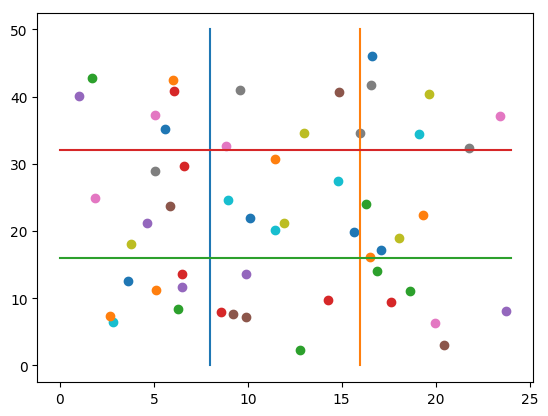

Team Sweet Spots: 54


In [36]:
using PyPlot
for i in 1:5
    for j in 1:9
        al = length(SS[coll[ateam][i][1:end-2]][j]) # Get the number of points in a zone
        if al > 0
            for n in 1:al
                # Plot the player sweet spots
                scatter(SS[coll[ateam][i][1:end-2]][j][n][1], SS[coll[ateam][i][1:end-2]][j][n][2]) 
            end
        end
    end
end

# Create the partitions
plot([8, 8],   [0, 50])
plot([16, 16], [0, 50])

plot([0, 24], [16, 16])
plot([0, 24], [32, 32])
# Number of sweet spots the optimal team has
println("Team Sweet Spots: ", lengths[ateam, 10])